# PID Racer
by Edwin Hartnell

## The Why

While PID controllers are a fundamental requirement of self-driving vehicles, it is difficult to experiment with PID controllers using a robotic kit car. This is because in order to calculate where the car should be, it is first necessary to calculate where the car actually is. This non-trivial localization problem uses most of the on-board sensor hardware, and the uncertainty overwhelms the downstream PID controller.

This PID Racer notebook provides an experimental template which eliminates the need to perform localization while allowing a robot to race around a circular track under a PID controller.

In addition to distance noise, steering noise, and steering drift, this code can simulate an additional real-world challenge: the reaction time of the steering command. While the electronic hardware may be quick to detect the cross-track error, there may be mechanical latency in conveying the command to the wheels. For a human driver, this may also be due to the driver's reaction time.

The code itself is self-contained and can be run without robotic hardware. But it is designed to be adapted into a real-world experiment as desired.

![Race Car turning on Circular Track](images/race-car-turning-002.jpg)

## Real-World Setup

To adapt this experiment to the physical world, a circular track should be laid out for the robot to travel. At the center of the track, place a cooking pot, potted plant, bin, or other cyclinder that can be detected by the robot. Several pots can be placed alongside one another to create a more advanced oval track. There is no need to paint (or tape) a line to the surface of the track, include landmarks, or add outside barriers (other than for safety).

With this configuration, the robotic car does not need to run a comprehensive localization algorithm to detect where it is. It is only necessary for the car to detect how far away it is from the pot forming the inner-barrier at the center of the track.

![Real-World Setup](images/pid-racer-track-005.png)

## Hardware Requirements

The robotic kit car should have an ultrasonic sensor that can detect the distance to the pot located at the center of the circular track. The kinetic bicycle model assumes that the distance to the pot is measured from the back wheels, but more often the ultrasonic sensor will be located over the front wheels. The sensor will have to be rotated so that it points towards the pot.

The robotic kit car should ideally have front wheels that can turn (like a regular car or a bicycle) with fixed back wheels. A robot with mecanum wheels is not ideally suited to this experiment.

![Ultrasonic Distance Sensor](images/robot-car-013.png)

## The Code

In this notebook, all the physical dimensions of the car and the track are defined as global constants. This includes the length of the car, the measurement noise and steering drift, this size of the world, and the location of the inner barrier (the pot). Note that this does *not* include the the arbitrary radius of the track which can be changed within the simulated experiment.

In [1]:
from math import *
import random
import matplotlib.pyplot as plt

# Global Constants
WORLD_SIZE = 2.0 # The size of the track is 4.0 x 4.0 meters (+/- 2.0 m in each direction) with the center of the track at the (0,0) origin
ROBOT_LENGTH = 0.2 # The length between the front (turning) wheel and the back (forward) wheel
ROBOT_STEERING_NOISE = 10.0 * pi / 180.0 # (degrees) The difference between the desired steering direction and the actual direction received by the wheels
ROBOT_DISTANCE_NOISE = 0.003 # (meters) The measurement noise in determining the distance to the center of the track
ROBOT_STEERING_DRIFT = 0.25 * pi / 180.0 # (degrees) The constant pull of the car left or right from straight ahead
PRINT_DEBUG_MESSAGES = False # Whether or not to print debug messages containing the position, speed, and cross-track error of the robot

# Set the desired distance to measure from the ultrasonic sensor
RADIUS_OF_INTERNAL_BARRIER = 0.1 # (meters) The radius of internal barrier (that is, the pot) sitting at the origin of the track
DESIRED_DISTANCE_FROM_INTERNAL_BARRIER = 0.5 # (meters) The desired distance between the robot and the internal barrier

## The Robot and The Track

The robot follows the kinetic bicycle model. It has front turning wheels and back fixed wheels that are 20 cm apart. The cross-track error (CTE) is the over/under distance from the back wheels to the pot (for a circular track) or internal barrier (for an oval track).

There may be reaction latency between the time the cross-track error was detected and the time a steering command was sent. This can also be thought of as the latency time the cross-track error was detected by the robot. The robot maintains a growing list of steering commands. If there is a delay then the robot will pipeline the steering commands and retrieve the command from reaction_time ago.

The track is a left-right symmetrical oval around the origin. If the length of the two straight edges on the north and south are zero then the track is a circle with a center at the origin. The robot travels clockwise around the track.

In [2]:
# Global Variables
robot_id_counter = 0 # Automatically increment the Robot ID counter whenever a new robot is created

class robot:
    """
    The robot follows the kinetic bicycle model. It has front turning wheels and
    back fixed wheels that are 20 cm apart. The cross-track error (CTE) is the over/under
    distance from the back wheels to the center of the track (for a circular track) or to
    the center of the nearest barrier (for an oval track).
    """

    def __init__(self):
        """
        By default, the robot is located at a random position and orientation in the world.
        The robot will need to be programmatically placed at the starting line.
        The robot suffers from steering noise, distance noise, and steering drift.
        """
        global robot_id_counter # Track the unique identifier of each robot created
        self.id = robot_id_counter # In this experiment, only one robot is required
        robot_id_counter += 1
        self.x = (2.0 * random.random() * WORLD_SIZE) - WORLD_SIZE # Locate the robot randomly in the world
        self.y = (2.0 * random.random() * WORLD_SIZE) - WORLD_SIZE
        self.orientation = random.random() * 2.0 * pi
        self.length = ROBOT_LENGTH # The length between the front (turning) wheel and the back (forward) wheel
        self.steering_noise = ROBOT_STEERING_NOISE # The difference between the desired steering direction and the actual direction received by the wheels
        self.distance_noise = ROBOT_DISTANCE_NOISE # The measurement noise in determining the distance to the center of the track
        self.steering_drift = ROBOT_STEERING_DRIFT # The constant pull of the car left or right from straight ahead
        self.steering_commands = [] # A growing list of steering commands sent to the robot - the robot may not use the latest if there is a reaction time delay
        self.reaction_time = 0 # The latency between the time the steering command was requested and the time it was sent to the wheels
        return

    def __str__(self):
        return f'[id={self.id}, length={self.length:.1f}, x={self.x:.3f}, y={self.y:.3f}, orientation={self.orientation:.3f}, div_pi={(self.orientation/pi):.3f}]'

    def __repr__(self):
        return f'id,{self.id},length,{self.length:.1f},x,{self.x:.3f},y,{self.y:.3f},orientation,{self.orientation:.3f},div_pi,{(self.orientation/pi):.3f},'

    def set_location(self, new_x, new_y, new_orientation):
        """
        Set the (x,y) position of the robot as well as its orientation.
            :param new_x: The x-position of the robot in the world
            :param new_y: The y-position of the robot in the world
            :param new_orientation: The orientation of the robot between 0.0 and 2*pi radians (0.0 faces the robot to the east / right)
        """
        if new_x < -WORLD_SIZE or new_x >= WORLD_SIZE:
            print(f"WARNING: X coordinate out of bounds: {self}")
        if new_y < -WORLD_SIZE or new_y >= WORLD_SIZE:
            print(f"WARNING: Y coordinate out of bounds: {self}")
        if new_orientation < 0.0 or new_orientation >= 2.0 * pi:
            print(f"WARNING: Orientation must be between [0..2pi]: {self}")
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)
        return

    def randomize_location(self):
        """
        Randomly set the (x,y) position of the robot as well as its orientation.
        """
        self.x = (2.0 * random.random() * WORLD_SIZE) - WORLD_SIZE
        self.y = (2.0 * random.random() * WORLD_SIZE) - WORLD_SIZE
        self.orientation = random.random() * 2.0 * pi

    def set_length(self, new_length):
        """
        Set the length of the robot. The length cannot be negative.
            :param new_length: The length between the front (turning) wheel and the back (forward) wheel
        """
        if new_length < 0.0:
            print(f"WARNING: Length cannot be negative: {self}")
            self.length = float(0.0)
        else:
            self.length = float(new_length)
        return

    def set_noise(self, new_steering_noise, new_distance_noise):
        """
        Set the steering noise noise and the measuring distance noise.
            :param new_steering_noise: The difference between the desired steering direction and the actual direction received by the wheels
            :param new_distance_noise: The measurement noise in determining the distance to the center of the track
        """
        self.steering_noise = float(new_steering_noise)
        self.distance_noise = float(new_distance_noise)

    def set_steering_drift(self, new_steering_drift):
        """
        Set the constant pull of the car left or right from straight ahead.
            :param new_steering_drift: The constant pull of the car left or right from straight ahead
        """
        self.steering_drift = float(new_steering_drift)
        return

    def set_reaction_time(self, new_reaction_time):
        """
        There may be a reaction time delay between the time the cross-track error
        was detected and the time a steering command was sent. This can also be thought
        of as the latency time the cross-track error was detected by the robot.
        The robot maintains a growing list of steering commands. If there is a delay
        then the robot will pipeline the steering commands and retrieve the command from
        reaction_time ago.
            :param new_reaction_time: The latency between the time the steering command was requested and the time it was sent to the wheels
        """
        self.steering_commands = []
        self.reaction_time = new_reaction_time
        return

    def str_noise(self):
        return f'[steering_noise={self.steering_noise:.3f}, distance_noise={self.distance_noise:.3f}, steering_drift={self.steering_drift:.3f}]'

    def repr_noise(self):
        return f'steering_noise,{self.steering_noise:.3f},distance_noise,{self.distance_noise:.3f},steering_drift,{self.steering_drift:.3f},'

    def cross_track_error(self, corner_radius=1.0, straight_length=0.0):
        """
        Calculate the Cross Track Error (CTE) based upon the shape of the track.
        The track is a left-right symmetrical oval around the origin.
        If the length of the two straight edges on the north and south are zero then the track is a circle with a center at the origin.
            :param corner_radius: The radius of the half-circles on the west/left and east/right hand sides of the track
            :param straight_length: The length of the straights on the north/top and south/bottom sides of the track
        """

        # North / Top Straight - CTE is how far north/south the robot is from the top straight
        if self.y >= 0.0 and self.x >= -straight_length/2.0 and self.x <= straight_length/2.0:
            cte = self.y - corner_radius
        # South / Bottom Straight - CTE is how far north/south the robot is from the bottom straight
        elif self.y < 0.0 and self.x >= -straight_length/2.0 and self.x <= straight_length/2.0:
            cte = -self.y - corner_radius
        # West / Left Curve - CTE is how far from the left semi-circle center
        elif self.x <= -straight_length/2.0:
            cte = ((self.x + straight_length/2.0)**2.0 + (self.y)**2.0)**0.5 - corner_radius
        # East / Right Curve - CTE is how far from the right semi-circle center
        elif self.x >= straight_length/2.0:
            cte = ((self.x - straight_length/2.0)**2.0 + (self.y)**2.0)**0.5 - corner_radius
        return cte

    def move(self, steering_command, forward_distance, maximum_steering_angle=pi/4.0, minimum_size_angle=0.001):
        """
        Move the robot in accordance to the kinetic bicycle model.
        Note that there may be a reaction time delay between the 'steering command' just sent
        and the actual 'turn angle' command passed onto the wheels.
            :param steering_command: The front wheel steering angle - note the 'turn_angle' is the 'steering_command' after the reaction time delay
            :param forward_distance: The total forward circular distance driven around an arc
            :param maximum_steering_angle: The maximum angle that the front wheel can steer
            :param minimum_size_angle: If the robot is turning less than this angle then the robot is deemed to be traveling 'straight'
        """
        self.steering_commands.append(steering_command)
        if len(self.steering_commands) > self.reaction_time:
            turn_angle = self.steering_commands[ len(self.steering_commands) - self.reaction_time - 1 ]
        else:
            turn_angle = 0.0
        if turn_angle > maximum_steering_angle:
            turn_angle = maximum_steering_angle
        if turn_angle < -maximum_steering_angle:
            turn_angle = -maximum_steering_angle
        if forward_distance < 0.0:
            print(f"WARNING: The robot cannot drive backwards: {self}")
            forward_distance = 0.0
        turn_angle_plus_steering_drift = turn_angle + self.steering_drift

        if self.length == 0.0 or abs(turn_angle_plus_steering_drift) < minimum_size_angle:
            self.orientation = ( self.orientation + float(turn_angle_plus_steering_drift) + random.gauss(0.0, self.steering_noise) ) % (2.0 * pi)
            forward_distance = float(forward_distance) + random.gauss(0.0, self.distance_noise)
            self.x += forward_distance * cos( self.orientation )
            self.y += forward_distance * sin( self.orientation )
        else:
            forward_distance = float(forward_distance) + random.gauss(0.0, self.distance_noise)
            steering_angle_alpha = float(turn_angle_plus_steering_drift) + random.gauss(0.0, self.steering_noise)
            turning_angle_beta = ( float(forward_distance) / self.length ) * tan(steering_angle_alpha)
            if abs(turning_angle_beta) < minimum_size_angle:
                self.orientation = ( self.orientation + turning_angle_beta ) % (2.0 * pi)
                self.x += forward_distance * cos( self.orientation )
                self.y += forward_distance * sin( self.orientation )
            else:
                turning_radius = forward_distance / turning_angle_beta
                cx = self.x - sin( self.orientation ) * turning_radius
                cy = self.y + cos( self.orientation ) * turning_radius
                self.orientation = ( self.orientation + turning_angle_beta ) % (2.0 * pi)
                self.x = cx + sin( self.orientation ) * turning_radius
                self.y = cy - cos( self.orientation ) * turning_radius
        if self.x < -WORLD_SIZE or self.x >= WORLD_SIZE:
            print(f"WARNING: X coordinate out of bounds: {self}")
        if self.y < -WORLD_SIZE or self.y >= WORLD_SIZE:
            print(f"WARNING: Y coordinate out of bounds: {self}")
        if self.orientation < 0.0 or self.orientation >= 2.0 * pi:
            print(f"WARNING: Orientation must be between [0..2pi]: {self}")
        return

## Run

While many of the physical dimensions of the car and the environment were set as constant values, there are many variables that can be set up with each virtual experiment. These include:

- The initial position and orientation of the robot on the track
- The PID control parameters used to control the robot given its cross-track error (CTE)
- The speed of the robot which equals the circular distance the robot travels each iteration
- The number of iterations to run the robot around the track
- The radius of the half-circles on the west/left and east/right sides of the track
- The length of the straights on the north/top and south/bottom sides of the track

The run() routine returns the absolute sum of the total cross-track error as an indication of parameter quality. This can be fed into a tuning routine to improve the PID control parameters. The routine also returns the position history of the robot which can be plotted in a scatterplot.

Note that in this software simulation, the cross-track error is calculated relative to the location of the robot. In a real-world experiment, this cross-track error would simply be replaced by the difference between the detected distance to the inner-barrier (the pot) and the desired difference. The required code has been included but commented out below.

In [3]:
def run(initial_x, initial_y, initial_orientation, control_parameters, robot_speed=0.1, number_of_iterations=100, reaction_time=0, corner_radius=1.0, straight_length=0.0):
    """
    Set the runtime conditions to race the robot around the track.
        :param initial_x: The initial x-position of the robot in the world
        :param initial_y: The initial y-position of the robot in the world
        :param initial_orientation: The initial orientation of the robot between 0.0 and 2*pi radians (0.0 faces the robot to the east / right)
        :param control_parameters: The PID parameters used to control the robot given its cross-track error (CTE)
        :param robot_speed: The speed of the robot equals the circular distance the robot travels each iteration
        :param number_of_iterations: The number of iterations to run the robot around the track
        :param corner_radius: The radius of the half-circles on the west/left and east/right hand sides of the track
        :param straight_length: The length of the straights on the north/top and south/bottom sides of the track
        :return absolute_sum_of_cross_track_error: Sum the total cross-track error as an indication of parameter quality
        :return position_history: A list of (x,y) tuples for each position of the robot as it travels around the track
    """

    # Initialize and locate the robot on the track - note that the noise parameters are set via global constants
    my_robot = robot()
    my_robot.set_location(initial_x, initial_y, initial_orientation)
    my_robot.set_reaction_time(reaction_time)

    # Track the location of the robot as it races around the track
    position_history = [(my_robot.x, my_robot.y)]

    # Retrieve each of the PID control parameters for the robot
    proportional_control_parameter = control_parameters[0]
    differential_control_parameter = control_parameters[1]
    integral_control_parameter = control_parameters[2]

    # Calculate the cross-track error using the ultrasonic sensor mounted to the robot
    # cross_track_error = my_robot.get_ultrasonic_distance() - DESIRED_DISTANCE_FROM_INTERNAL_BARRIER
    # previous_cross_track_error = cross_track_error

    # Alternatively, calculate the simulated cross-track error and save it so that the differential change of error can be calculated
    cross_track_error = my_robot.cross_track_error(corner_radius, straight_length)
    previous_cross_track_error = cross_track_error

    # Update the user on the state of the simulation
    if PRINT_DEBUG_MESSAGES:
        print(f'iteration,0,{repr(my_robot)},my_robot.move,steering,{0.0:.3f},robot_speed,{robot_speed:.3f},cte,{previous_cross_track_error:.3f},')

    # Sum all of the previous cross-track errors so that the intergral error can be calculated
    sum_cross_track_error = 0.0

    # Iteratively move the robot around the track adjusting its steering angle according to the PID controller
    absolute_sum_of_cross_track_error = 0.0
    for i in range(number_of_iterations):

        # Calculate the cross-track error using the ultrasonic sensor mounted to the robot
        # cross_track_error = my_robot.get_ultrasonic_distance() - DESIRED_DISTANCE_FROM_INTERNAL_BARRIER
        # previous_cross_track_error = cross_track_error

        # Alternatively, calculate the simulated cross-track error if the robot's ultrasonic sensor is not available
        cross_track_error = my_robot.cross_track_error(corner_radius, straight_length)
        delta_cross_track_error = cross_track_error - previous_cross_track_error
        sum_cross_track_error += cross_track_error
        steering_command = - cross_track_error * proportional_control_parameter - delta_cross_track_error * differential_control_parameter - sum_cross_track_error * integral_control_parameter

        # Send the steering command to the robot - but there may be latency before the command arrives due to the reaction time delay
        my_robot.move(steering_command, robot_speed)
        position_history.append((my_robot.x, my_robot.y))

        # Update the user on the state of the simulation
        if PRINT_DEBUG_MESSAGES:
            print(f'iteration,{i+1},{repr(my_robot)},my_robot.move,steering,{steering_command:.3f},robot_speed,{robot_speed:.3f},cte,{cross_track_error:.3f},')
        previous_cross_track_error = cross_track_error
        absolute_sum_of_cross_track_error += abs(cross_track_error) # Sum the total cross-track error as an indication of parameter quality
    return absolute_sum_of_cross_track_error, position_history

## Experiment 1: In-Control

Start the Robot running around the track with reasonable levels of noise, quick reaction time, and good control parameters.

In [4]:
# Define the dimensions of the circular / oval track
corner_radius = 0.5
straight_length = 1.0

# Place the robot on the track ready to start racing
initial_x = 0.0 # The robot is initially located 1-radius above the origin on the track
initial_y = corner_radius
initial_orientation = 0.0 # pi / 2.0 # The robot is facing east ready to drive clockwise around the track

# Define the PID parameters used to control the steering of the robot around the track
proportional_control_parameter = 50.0
differential_control_parameter = 150.0
integral_control_parameter = 0.1
control_parameters = [proportional_control_parameter, differential_control_parameter, integral_control_parameter]

# Set the robot's speed and the number of iterations to run
robot_speed = 0.03
reaction_time = 0
number_of_iterations = 200

# Go! Race the robot around the track
cte_sum, position_history = run(initial_x, initial_y, initial_orientation, control_parameters, robot_speed, number_of_iterations, reaction_time, corner_radius, straight_length)

print(f'The absolute sum of the cross-track error (cte) is: {cte_sum:.3f}')

The absolute sum of the cross-track error (cte) is: 0.862


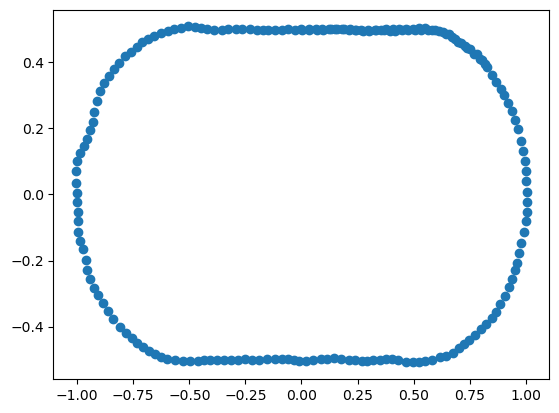

In [5]:
# Plot the position of the PID-controlled robot as it progresses around the track

position_history_zip = list(zip(*position_history))
plt.scatter(list(position_history_zip[0]),list(position_history_zip[1]))
plt.show()

## Experiment 2: Out-of-Control

Repeat the earlier experiment except with slower reaction time. Can also increase the speed of the robot, the sensor noise, the steering noise, and the steering drift.

In [8]:
# Define the dimensions of the circular / oval track
corner_radius = 0.5
straight_length = 1.0

# Place the robot on the track ready to start racing
initial_x = 0.0 # The robot is initially located 1-radius above the origin on the track
initial_y = corner_radius
initial_orientation = 0.0 # pi / 2.0 # The robot is facing east ready to drive clockwise around the track

# Define the PID parameters used to control the steering of the robot around the track
proportional_control_parameter = 50.0
differential_control_parameter = 150.0
integral_control_parameter = 0.1
control_parameters = [proportional_control_parameter, differential_control_parameter, integral_control_parameter]

# Change the noise, drift, and reaction time
# ROBOT_STEERING_NOISE = 10.0 * pi / 180.0 ## These global constants can be changed here and then picked up in the run() routine
# ROBOT_DISTANCE_NOISE = 0.003
# ROBOT_STEERING_DRIFT = 0.25 * pi / 180.0
reaction_time = 1 #### SLOW DOWN THE REACTION TIME - it takes 1 iteration delay for the robot to receive the command

# Set the robot's speed and the number of iterations to run
robot_speed = 0.03
number_of_iterations = 200

# Go! Race the robot around the track
cte_sum, position_history = run(initial_x, initial_y, initial_orientation, control_parameters, robot_speed, number_of_iterations, reaction_time, corner_radius, straight_length)

print(f'The absolute sum of the cross-track error (cte) is: {cte_sum:.3f}')

The absolute sum of the cross-track error (cte) is: 5.169


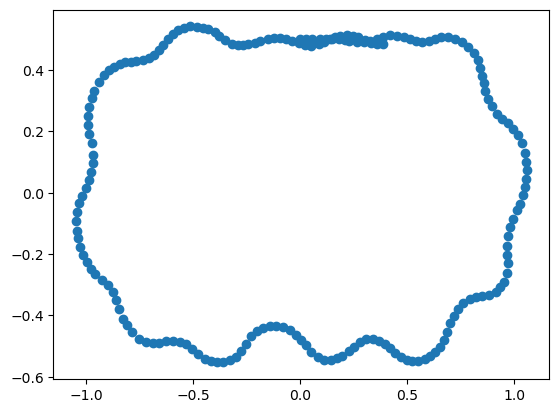

In [9]:
# Plot the position of the PID-controlled robot as it progresses around the track

position_history_zip = list(zip(*position_history))
plt.scatter(list(position_history_zip[0]),list(position_history_zip[1]))
plt.show()